In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import importlib
import matplotlib
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import sys
import os
import snn_lib.utilities as utilities
from snn_lib.snn_layers import *

# Configurations

In [2]:
dataset_path = './dataset/associative_target.npy'

checkpoint_base_name = "associative_memory_checkpoint_"
checkpoint_base_path = './associative_memory_checkpoint/'

torch.manual_seed(2)
np.random.seed(0)

length = 300
input_size = 300
batch_size = 64
synapse_type = 'dual_exp'
epoch = 50
tau_m = 8
tau_s = 2
filter_tau_m = tau_m
filter_tau_s = tau_s
dropout_rate = 0.3

modify_input_prob = 0.6
remove_prob = 0.5
remove_row_prob = 0.2
remove_col_prob = 0.2
remove_block_prob = 0.2
mutate_prob = 0.7
noise_prob = 0.005

remove_block_h = 30
remove_block_w = 40
remove_block_h = 40
remove_col_w = 30
remove_row_h = 30

optimizer_choice = 1
scheduler_choice = 1

optimizer_config = {0: (torch.optim.Adam,       0.001),
                    1: (torch.optim.AdamW,      0.001),
                    2: (torch.optim.SGD,        0.0001)}

scheduler_config = {0: None,
                    1: (torch.optim.lr_scheduler.MultiStepLR, [50,100, 150], 0.1),
                    # order: milestones, gamma=0.1
                    2: (torch.optim.lr_scheduler.CosineAnnealingWarmRestarts, 1000),
                    # T_0
                    3: (torch.optim.lr_scheduler.CyclicLR, 0.001, 0.01, 200)
                    }

# Prepare dataset

In [3]:
# %% utility functions
def add_noise_spike(spike_array,probability = 0.003):
    '''
    :param spike_array: 2d array [spike train num, length]
    :param probability:
    :return:
    '''
    noise_mat = np.random.rand(*spike_array.shape).astype(np.float32)

    noise_mat[np.where(noise_mat > 1-probability)] = 1
    noise_mat[np.where(noise_mat <= 1 - probability)] = 0

    new_arr = spike_array + noise_mat

    new_arr[np.where(new_arr > 1)] = 1

    return  new_arr

def remove_row(spike_array,remove_width, position = None):
    '''
    remove a few rows in the spike mat (set rows to 0)
    :param spike_array: 2d array [spike train num, length]
    :param remove_width: How many rows to remove
    :param position: spike will be removed from row position to position+remove_width
    :return:
    '''

    h,w = spike_array.shape
    upper_row = np.random.randint(0,h-remove_width)

    if position != None:
        upper_row = position

    new_arr = spike_array
    new_arr[upper_row:upper_row+remove_width,:] = 0

    return new_arr

def remove_col(spike_array,remove_width):
    '''
    remove a few columns in spike mat (set columns to 0)
    :param spike_array: 2d array [spike train num, length]
    :param width:
    :return:
    '''

    h,w = spike_array.shape
    left_col = np.random.randint(0,w-remove_width)

    new_arr = spike_array
    new_arr[:,left_col:left_col+remove_width] = 0

    return new_arr

def remove_block(spike_array,remove_hight, remove_width):
    '''
    set a block region in spike mat to 0
    :param spike_array: 2d array [spike train num, length]
    :param width:
    :return:
    '''

    h,w = spike_array.shape
    top_left_row = np.random.randint(0,w-remove_hight)
    top_left_col = np.random.randint(0,w-remove_width)

    new_arr = spike_array
    new_arr[top_left_row:top_left_row+remove_hight,top_left_col:top_left_col+remove_width] = 0

    return new_arr

class PatternDataset(Dataset):
    """random pattern dataset"""

    def __init__(self, input_pattern, target, filtered_target,length):
        '''

        :param input_pattern: [number, hight, width/time]
        :param label_cat:
        :param target:
        :param length:
        '''
        self.input_pattern = input_pattern
        self.target = target
        self.filtered_target = filtered_target
        self.length = length


        self.modify_input_prob = modify_input_prob
        self.remove_prob = remove_prob
        self.remove_row_prob = remove_row_prob
        self.remove_col_prob = remove_col_prob
        self.noise_prob = noise_prob
        self.mutate_prob = mutate_prob

        self.remove_block_h = remove_block_h
        self.remove_block_w = remove_block_w
        self.remove_block_h =remove_block_h
        self.remove_col_w = remove_col_w
        self.remove_row_h = remove_row_h

    def __len__(self):
        #input only has 10 samples, so increase length by 100
        #each sample is a class
        return len(self.input_pattern)*100

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #input data only has 10 sample
        #by mod get the actual idx, which is also the class
        real_idx = idx % 10

        label = real_idx
        input_pattern = self.input_pattern[real_idx].copy()
        output_target = self.target[real_idx]
        filtered_target = self.filtered_target[real_idx]

        if np.random.rand() > self.modify_input_prob:
            #modify input data, remove, delete, add noise, mutate
            if np.random.rand() < self.mutate_prob:
                input_pattern = utilities.mutate_spike_pattern(input_pattern, 0, 1)

            #random select remove row, col, or block
            choice = np.random.randint(2)

            if np.random.rand() < self.remove_prob:
                if choice == 0:
                    input_pattern = remove_block(input_pattern,remove_block_w, remove_block_h)
                elif choice == 1:
                    input_pattern = remove_row(input_pattern, remove_block_h)

        input_pattern = add_noise_spike(input_pattern, self.noise_prob)

        return input_pattern, label, output_target, filtered_target

# Build the network

In [4]:
class mysnn(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.length = length
        self.batch_size = batch_size

        self.train_coefficients = True
        self.train_decay_v = False
        self.train_v0 = False
        self.train_reset_v = False
        self.train_reset_decay = False
        self.train_threshold = False
        self.train_bias = True
        self.membrane_filter = False

        self.axon1 = dual_exp_iir_layer((input_size,), self.length, 
        self.batch_size, tau_m, tau_s, self.train_coefficients)

        self.dense1 = neuron_layer(input_size, 500, self.length, self.batch_size, 
        tau_m, self.train_bias, self.membrane_filter)

        self.axon2 = dual_exp_iir_layer((500,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)
        self.dense2 = neuron_layer(500, 200, self.length, self.batch_size, tau_m,  
        self.train_bias, self.membrane_filter)
                    
        self.axon3 = dual_exp_iir_layer((200,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)

        self.dense3 = neuron_layer(200, 500, self.length, self.batch_size, tau_m, 
        self.train_bias, self.membrane_filter)
        
        self.axon4 = dual_exp_iir_layer((500,), self.length, self.batch_size, tau_m, tau_s, 
        self.train_coefficients)

        self.dense4 = neuron_layer(500, 300, self.length, self.batch_size, tau_m, 
        self.train_bias, self.membrane_filter)

        self.output_filter = filter_layer(300, self.length, self.batch_size, filter_tau_m, filter_tau_s)                                
    def forward(self, inputs):
        """
        :param inputs: [batch, input_size, t]
        :return:
        """
        axon1_states = self.axon1.create_init_states()
        dense1_states = self.dense1.create_init_states()

        axon2_states = self.axon2.create_init_states()
        dense2_states = self.dense2.create_init_states()

        axon3_states = self.axon3.create_init_states()
        dense3_states = self.dense3.create_init_states()

        axon4_states = self.axon4.create_init_states()
        dense4_states = self.dense4.create_init_states()

        axon1_out, axon1_states = self.axon1(inputs, axon1_states)
        spike_dense1, dense1_states = self.dense1(axon1_out, dense1_states)

        axon2_out, axon2_states = self.axon2(spike_dense1, axon2_states)
        spike_dense2, dense2_states = self.dense2(axon2_out, dense2_states)

        axon3_out, axon3_states = self.axon3(spike_dense2, axon3_states)
        spike_dense3, dense3_states = self.dense3(axon3_out, dense3_states)

        axon4_out, axon4_states = self.axon4(spike_dense3, axon4_states)
        spike_dense4, dense4_states = self.dense4(axon4_out, dense4_states)

        filtered_output = self.output_filter(spike_dense4)

        return spike_dense4, filtered_output

# Train and test function

In [5]:
def train(model, optimizer, scheduler, data_loader):
    '''

    '''

    model.train()

    eval_image_number = 0
    correct_total = 0
    wrong_total = 0

    criterion = torch.nn.MSELoss()

    for i_batch, sample_batched in enumerate(data_loader):

        x_train = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        target_pattern = sample_batched[2].to(device)
        filtered_target_pattern = sample_batched[3].to(device)

        out_spike, filtered_out_spike = model(x_train)

        model.zero_grad()

        loss = criterion(filtered_out_spike, filtered_target_pattern)

        print('train loss: {}'.format(loss))

        loss.backward()

        optimizer.step()

        if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts) or \
                isinstance(scheduler, torch.optim.lr_scheduler.CyclicLR):
            # isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()

    if isinstance(scheduler, torch.optim.lr_scheduler.MultiStepLR):
        scheduler.step()

    return loss

def test(model, data_loader):

    model.eval()

    loss_list = []

    criterion = torch.nn.MSELoss()

    for i_batch, sample_batched in enumerate(data_loader):

        criterion = torch.nn.MSELoss()
        x_test = sample_batched[0].to(device)
        label = sample_batched[1].to(device)
        target_pattern = sample_batched[2].to(device)
        filtered_target_pattern = sample_batched[3].to(device)

        out_spike, filtered_out_spike = model(x_test)

        loss = criterion(filtered_out_spike, filtered_target_pattern)

        print('Test loss: {}'.format(loss))

        loss_list.append(loss.cpu().detach().numpy())

    #calculate loss of this epoch
    loss_array = np.stack(loss_list)
    average_loss = loss_array.mean()

    return average_loss

# Train the network

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

original_pattern = np.load(dataset_path).astype(np.float32)

delayed_target = np.zeros(original_pattern.shape, dtype=np.float32)

delayed_target[:, :, 4:] = original_pattern[:, :, :-4]

filtered_target = []
for target_idx, delayed_target_pattern in enumerate(delayed_target):
    filtered_target.append(utilities.filter_spike_multiple(delayed_target_pattern, filter_type='dual_exp',
                                                            tau_m=filter_tau_m, tau_s=filter_tau_s))
# shape [pattern idx, spike train idx, time]
filtered_target = np.array(filtered_target)

snn = mysnn().to(device)

params = list(snn.parameters())

optimizer_class = optimizer_config[optimizer_choice][0]
learning_rate = optimizer_config[optimizer_choice][1]
optimizer = optimizer_class(params, learning_rate)

scheduler = None
if scheduler_choice == 0:
    scheduler = None
elif scheduler_choice == 1:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2])
elif scheduler_choice == 2:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, scheduler_config[scheduler_choice][1])
elif scheduler_choice == 3:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2], 
    scheduler_config[scheduler_choice][3])
elif scheduler_choice == 4:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
    scheduler_config[scheduler_choice][1], 
    scheduler_config[scheduler_choice][2], 
    scheduler_config[scheduler_choice][3])

## Train and test dataloader

In [7]:
train_data = PatternDataset(original_pattern, delayed_target, filtered_target, length)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

test_data = PatternDataset(original_pattern, delayed_target, filtered_target, length)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

## Train

In [8]:
best_epoch = 0
lowest_loss = 100

for j in range(epoch):
    print('Train epoch: {}'.format(j))

    snn.train()

    train_loss = train(snn, optimizer, scheduler, train_dataloader)

    save_checkpoint = True
    if save_checkpoint:
        checkpoint_path = os.path.join(checkpoint_base_path, checkpoint_base_name + str(j))
        torch.save({
            'epoch': j,
            'snn_state_dict': snn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, checkpoint_path)
    
    snn.eval()
    average_loss = test(snn, test_dataloader)
    if lowest_loss > average_loss:
        lowest_loss = average_loss
        best_epoch = j
    
    print('Test: {}, loss: {}'.format(j, average_loss))

print('Best epoch: {}'.format(best_epoch))

Train epoch: 0
train loss: 0.14626167714595795
train loss: 0.14835956692695618
train loss: 0.13804279267787933
train loss: 0.13652704656124115
train loss: 0.14069853723049164
train loss: 0.13243697583675385
train loss: 0.14614921808242798
train loss: 0.14536656439304352
train loss: 0.13760292530059814
train loss: 0.1447148472070694
train loss: 0.147738516330719
train loss: 0.15015029907226562
train loss: 0.14411300420761108
train loss: 0.13761238753795624
train loss: 0.13708558678627014
Test loss: 0.14490272104740143
Test loss: 0.1378292590379715
Test loss: 0.1418544054031372
Test loss: 0.13716210424900055
Test loss: 0.15260793268680573
Test loss: 0.13973207771778107
Test loss: 0.14842155575752258
Test loss: 0.14250971376895905
Test loss: 0.14396023750305176
Test loss: 0.13424377143383026
Test loss: 0.13412973284721375
Test loss: 0.14147736132144928
Test loss: 0.14259691536426544
Test loss: 0.14371900260448456
Test loss: 0.14347894489765167
Test: 0, loss: 0.14190837740898132
Train epoc

train loss: 0.08435660600662231
train loss: 0.08522183448076248
train loss: 0.08356638252735138
train loss: 0.08128736168146133
train loss: 0.08067043870687485
train loss: 0.08098981529474258
Test loss: 0.08304991573095322
Test loss: 0.08203260600566864
Test loss: 0.08152969181537628
Test loss: 0.08540234714746475
Test loss: 0.0820479691028595
Test loss: 0.07950422912836075
Test loss: 0.08207087963819504
Test loss: 0.07996091991662979
Test loss: 0.08163521438837051
Test loss: 0.08290906995534897
Test loss: 0.07901936769485474
Test loss: 0.08154457807540894
Test loss: 0.0812392607331276
Test loss: 0.08205021172761917
Test loss: 0.08346319198608398
Test: 8, loss: 0.08183062821626663
Train epoch: 9
train loss: 0.08253121376037598
train loss: 0.08159017562866211
train loss: 0.08077719062566757
train loss: 0.07828177511692047
train loss: 0.0770212709903717
train loss: 0.07900665700435638
train loss: 0.08136972784996033
train loss: 0.07832647860050201
train loss: 0.07584930956363678
train lo

Test loss: 0.11524523794651031
Test loss: 0.11656773090362549
Test loss: 0.1143731027841568
Test loss: 0.11660420894622803
Test loss: 0.11211401969194412
Test loss: 0.1197260394692421
Test loss: 0.11326723545789719
Test loss: 0.11814811080694199
Test loss: 0.11598788946866989
Test loss: 0.11809659749269485
Test loss: 0.11582241952419281
Test loss: 0.11446777731180191
Test loss: 0.11784381419420242
Test: 16, loss: 0.11619279533624649
Train epoch: 17
train loss: 0.11609431356191635
train loss: 0.1296427994966507
train loss: 0.11902404576539993
train loss: 0.10662311315536499
train loss: 0.10846619307994843
train loss: 0.1167263463139534
train loss: 0.10800924897193909
train loss: 0.10177784413099289
train loss: 0.10704027861356735
train loss: 0.10549688339233398
train loss: 0.09545103460550308
train loss: 0.10295512527227402
train loss: 0.10464189201593399
train loss: 0.09750909358263016
train loss: 0.09075409173965454
Test loss: 0.09768285602331161
Test loss: 0.09878786653280258
Test lo

Test loss: 0.05568397417664528
Test loss: 0.054906927049160004
Test loss: 0.05450503155589104
Test loss: 0.054857946932315826
Test loss: 0.055566754192113876
Test loss: 0.0545511357486248
Test: 24, loss: 0.05533758923411369
Train epoch: 25
train loss: 0.05343728885054588
train loss: 0.05562352389097214
train loss: 0.057154331356287
train loss: 0.054086994379758835
train loss: 0.05292088910937309
train loss: 0.05422889441251755
train loss: 0.05500815063714981
train loss: 0.055092278867959976
train loss: 0.05444778874516487
train loss: 0.05785130336880684
train loss: 0.05622513219714165
train loss: 0.05671246722340584
train loss: 0.05446626618504524
train loss: 0.05648883059620857
train loss: 0.05410563200712204
Test loss: 0.05505711957812309
Test loss: 0.056923747062683105
Test loss: 0.05751755088567734
Test loss: 0.05480587109923363
Test loss: 0.05383184924721718
Test loss: 0.0561460517346859
Test loss: 0.0547291561961174
Test loss: 0.055607713758945465
Test loss: 0.05535195395350456
T

Test loss: 0.048107508569955826
Test: 32, loss: 0.04760083183646202
Train epoch: 33
train loss: 0.04788504168391228
train loss: 0.04522968456149101
train loss: 0.04580310359597206
train loss: 0.04740529507398605
train loss: 0.04721162095665932
train loss: 0.048693474382162094
train loss: 0.047519661486148834
train loss: 0.046295128762722015
train loss: 0.04480680078268051
train loss: 0.049240440130233765
train loss: 0.04501786828041077
train loss: 0.04649481922388077
train loss: 0.04485544562339783
train loss: 0.045774154365062714
train loss: 0.047901418060064316
Test loss: 0.045649733394384384
Test loss: 0.04594898968935013
Test loss: 0.04630643501877785
Test loss: 0.04681723192334175
Test loss: 0.0466654971241951
Test loss: 0.04693217948079109
Test loss: 0.047592177987098694
Test loss: 0.0470089316368103
Test loss: 0.04636489227414131
Test loss: 0.045165203511714935
Test loss: 0.04462612792849541
Test loss: 0.045396141707897186
Test loss: 0.04584340751171112
Test loss: 0.044817030429

train loss: 0.0399324856698513
train loss: 0.03816734626889229
train loss: 0.04137789085507393
train loss: 0.038825102150440216
train loss: 0.03958246484398842
train loss: 0.03946048766374588
train loss: 0.04017581790685654
train loss: 0.03871522098779678
train loss: 0.04039895161986351
train loss: 0.03704177588224411
train loss: 0.03997799754142761
train loss: 0.0393560566008091
train loss: 0.040320105850696564
Test loss: 0.04211271554231644
Test loss: 0.0393504835665226
Test loss: 0.039803192019462585
Test loss: 0.04021451249718666
Test loss: 0.0386195108294487
Test loss: 0.040025465190410614
Test loss: 0.040761303156614304
Test loss: 0.04026036337018013
Test loss: 0.03995495289564133
Test loss: 0.04329267516732216
Test loss: 0.04112847149372101
Test loss: 0.0398881770670414
Test loss: 0.03991089388728142
Test loss: 0.03961210325360298
Test loss: 0.04058382287621498
Test: 41, loss: 0.040367912501096725
Train epoch: 42
train loss: 0.03870494291186333
train loss: 0.04014485701918602
tr

train loss: 0.034440599381923676
train loss: 0.033237580209970474
train loss: 0.03384171426296234
train loss: 0.03404422104358673
train loss: 0.03368040546774864
train loss: 0.033555928617715836
train loss: 0.02954082004725933
Test loss: 0.030986083671450615
Test loss: 0.0317842923104763
Test loss: 0.032238464802503586
Test loss: 0.03293797746300697
Test loss: 0.03302440419793129
Test loss: 0.03126786649227142
Test loss: 0.032520145177841187
Test loss: 0.03354198485612869
Test loss: 0.0321907214820385
Test loss: 0.031457480043172836
Test loss: 0.032289329916238785
Test loss: 0.03325378894805908
Test loss: 0.03234744817018509
Test loss: 0.031642839312553406
Test loss: 0.031097641214728355
Test: 49, loss: 0.032172031700611115
Best epoch: 49


## Run the best epoch

In [9]:
input_list = []
output_list = []

# checkpoint_path = os.path.join(checkpoint_base_path, checkpoint_base_name + str(best_epoch))
# checkpoint = torch.load(checkpoint_path)

# You can replpace checkpoint_path by a pre-trained checkpoint
checkpoint_path = './associative_memory_checkpoint/pretrained_associative_memory'
checkpoint = torch.load(checkpoint_path)

snn.load_state_dict(checkpoint["snn_state_dict"])

print('Checkpoint: {} loaded'.format(checkpoint_path))

snn.eval()

for i_batch, sample_batched in enumerate(test_dataloader):

    criterion = torch.nn.MSELoss()
    x_test = sample_batched[0].to(device)
    label = sample_batched[1].to(device)
    target_pattern = sample_batched[2].to(device)
    filtered_target_pattern = sample_batched[3].to(device)

    out_spike, filtered_out_spike = snn(x_test)

    loss = criterion(filtered_out_spike, filtered_target_pattern)

    print(i_batch, loss)

    input_list.append(x_test.cpu().detach().numpy())
    output_list.append(out_spike.cpu().detach().numpy())

Checkpoint: ./associative_memory_checkpoint/pretrained_associative_memory loaded
0 tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward>)

## Plot some samples

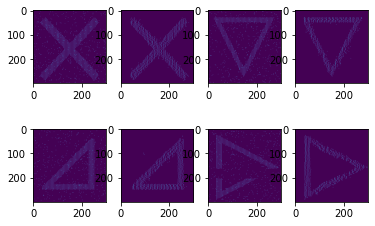

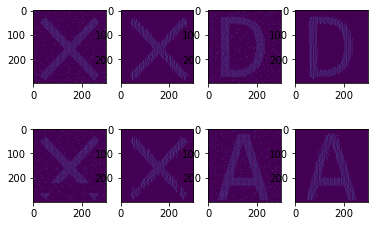

<Figure size 432x288 with 0 Axes>

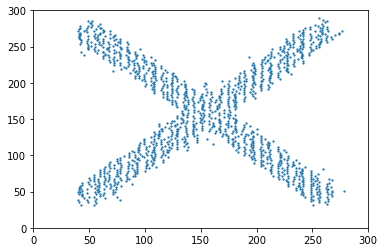

<Figure size 432x288 with 0 Axes>

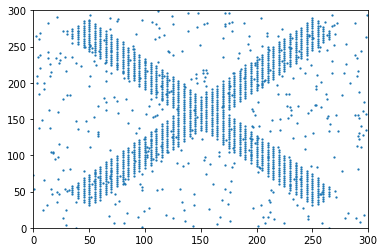

In [10]:
fig, axs = plt.subplots(2, 4)
axs[0, 0].imshow(input_list[0][0])
axs[0, 1].imshow(output_list[0][0])

axs[1, 0].imshow(input_list[0][1])
axs[1, 1].imshow(output_list[0][1])

axs[0, 2].imshow(input_list[0][2])
axs[0, 3].imshow(output_list[0][2])

axs[1, 2].imshow(input_list[0][3])
axs[1, 3].imshow(output_list[0][3])

fig, axs = plt.subplots(2, 4)
axs[0, 0].imshow(input_list[0][25])
axs[0, 1].imshow(output_list[0][25])

axs[1, 0].imshow(input_list[0][26])
axs[1, 1].imshow(output_list[0][26])

axs[0, 2].imshow(input_list[0][23])
axs[0, 3].imshow(output_list[0][23])

axs[1, 2].imshow(input_list[0][27])
axs[1, 3].imshow(output_list[0][27])

plt.figure()
utilities.plot_raster_dot(output_list[0][0])
plt.figure()
utilities.plot_raster_dot(input_list[0][0])

In [48]:
# len(input_list), len(input_list[0]), len(output_list), len(output_list[0])

In [47]:
# utilities.plot_raster_dot(input_list[0][0])
# utilities.plot_raster_dot(output_list[0][0])

In [46]:
# utilities.plot_raster_dot(input_list[0][2])
# utilities.plot_raster_dot(output_list[0][2])

In [45]:
# utilities.plot_raster_dot(input_list[0][9])
# utilities.plot_raster_dot(output_list[0][9])

In [44]:
# utilities.plot_raster_dot(input_list[10][14])
# utilities.plot_raster_dot(output_list[10][14])